## Get for all the core spp the branchwater results
- Make a presence absense table for all SRAs
- Convert the BW output to a [sra, num_spp] df
- Use this


In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

In [2]:
files = glob.glob("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/*.csv")


In [3]:

# 2. Read all CSVs and keep only ['acc', 'organism']
dfs = [pd.read_csv(f, usecols=['acc', 'organism', 'assay_type', 'bioproject']) for f in files]

# 3. Concatenate them
combined = pd.concat(dfs, ignore_index=True)
combined = combined[combined['organism'] != 'NP']
combined = combined[combined['assay_type'] == 'WGS']

# 4. Count duplicates
result = (
    combined
    .value_counts(['acc', 'organism','bioproject'])
    .reset_index(name='count')
)

# 5. (Optional) sort by count
result = result.sort_values('count', ascending=False)


In [4]:
# 105,880 results
len(result)

105880

In [5]:
df_pivot = pd.crosstab(result['organism'], result['count']).reset_index()
df_pivot.columns = ['organism'] + [str(col) for col in df_pivot.columns[1:]]

In [6]:
# SAME BUT SIMPLE
category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa']}


# Function to assign category based on keywords
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  # default if no keywords match


df_pivot['broad_cat'] = df_pivot['organism'].apply(get_broad_cat_simple)

In [26]:
numeric_cols = df_pivot.select_dtypes(include='number').columns.tolist()
df_grouped = df_pivot.groupby('broad_cat')[numeric_cols].sum().reset_index()
species_cols = [str(i) for i in range(1, 15)]



In [8]:
def plot_cat(df):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    df_abs = df.set_index('broad_cat')[numeric_cols]
    ax = df_abs.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
    ax.set_ylabel('Number of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 20)')
    plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()


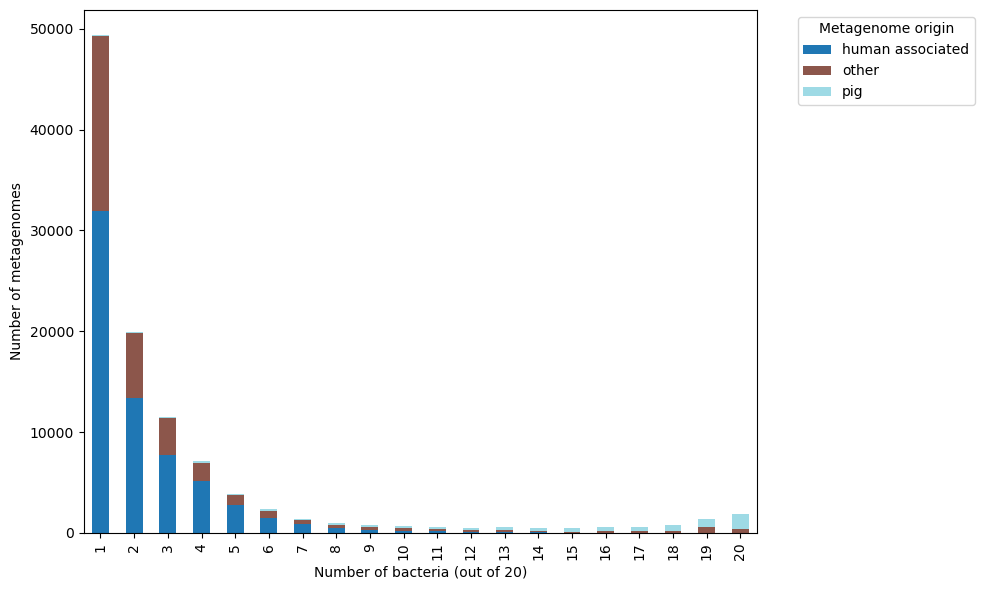

In [9]:
# # make chart with absolute numbers
# numeric_cols = df_grouped.select_dtypes(include='number').columns.tolist()

# df_abs = df_grouped.set_index('broad_cat')[numeric_cols]
# ax = df_abs.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
# ax.set_ylabel('Number of metagenomes')
# ax.set_xlabel('Number of bacteria (out of 20)')

# plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left')
# #plt.yscale('log')
# plt.tight_layout()
plot_cat(df_grouped)

In [42]:
def plot_cat_percent(df):
    df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100

    # Plot stacked bar chart
    ax = df_norm.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
    ax.set_ylabel('Percent of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 20)')
    plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()


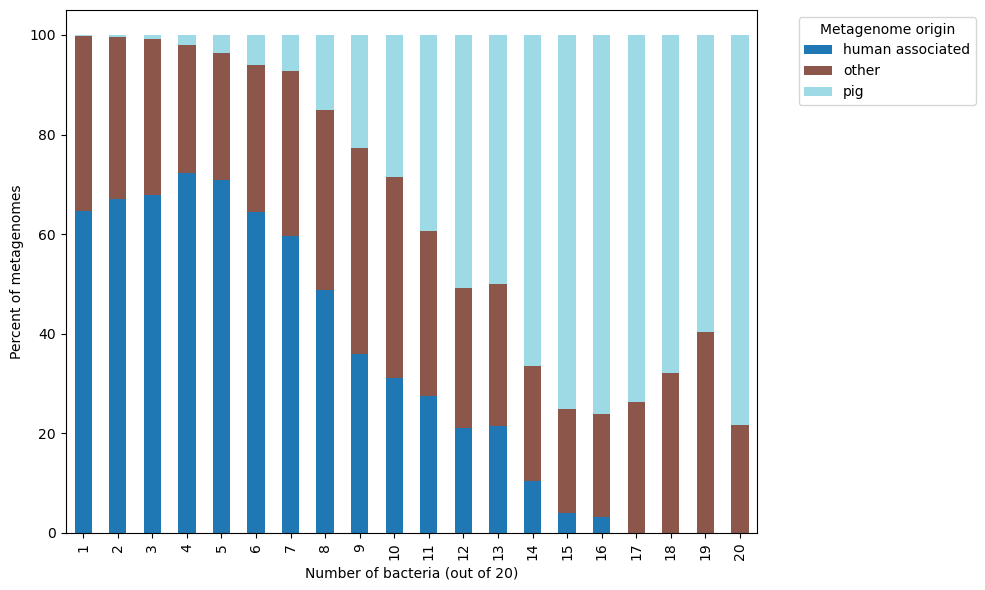

In [11]:
# Automatically select numeric columns
numeric_cols = df_grouped.select_dtypes(include='number').columns.tolist()

plot_cat_percent(df_grouped)

## Do some manual curation on metadata:
- Many samples logged as "metagenome" or "gut metagenome" 
- Are theys in actuality pig?
- Move everything with the tag 'other' and look at the SRAs

In [12]:
result['broad_cat'] = result['organism'].apply(get_broad_cat_simple)

In [ ]:
# from where on do we need to mancur
# count 1
subset = result[result['count'] == 1]   # or == 1, >= 3, etc.

# 2. Value counts of organism
organism_counts = subset['organism'].value_counts().reset_index()
organism_counts.columns = ['organism', 'num_occurrences']



                          organism  num_occurrences
0             human gut metagenome            26493
1                   gut metagenome             6342
2                       metagenome             4187
3                 human metagenome             2487
4                     Homo sapiens             2205
..                             ...              ...
165  Erysipelotrichaceae bacterium                1
166   Porphyromonadaceae bacterium                1
167                peat metagenome                1
168               Diceros bicornis                1
169           Campylobacter jejuni                1

[170 rows x 2 columns]


In [62]:
other_mg = result[result['broad_cat'] == 'other']
other_mg.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251111_metag_other.branchwater.csv')

In [75]:
# Average per bioproject–organism–broad_cat, plus total per bioproject
counts_bp = (
    other_mg
    .groupby(['bioproject', 'organism', 'broad_cat'], as_index=False)
    .agg(
        avg_count=('count', 'mean'),
        bioproject_total=('bioproject', 'count')  # how many rows that bioproject has
    )
    .sort_values('avg_count', ascending=False)
)

print(counts_bp.head())


       bioproject           organism broad_cat  avg_count  bioproject_total
1259  PRJNA633402  manure metagenome     other  20.000000                 4
1652  PRJNA847183   feces metagenome     other  20.000000                 1
1267  PRJNA640717   feces metagenome     other  20.000000                 2
1588  PRJNA801755     gut metagenome     other  19.833333                 6
1832  PRJNA951897   feces metagenome     other  19.600000                10


In [76]:

counts_bp.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251111_metag_other.bioPcounts.csv')

In [ ]:
# 4416 bioprojects. With designation 'other'
len(counts_bp)

4416

In [13]:
# load mancur
df_mancur = pd.read_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251111_metag_mancur.csv')

In [21]:
# 1. Merge the manual info into result
df2 = result.merge(
    df_mancur[['bioproject', 'manual_org']],
    on='bioproject',
    how='left'
)

# 2. Replace broad_cat with manual_org wherever manual_org is not null
df2['organism'] = df2['manual_org'].combine_first(df2['organism'])

# 3. Drop the helper column if you want
df2 = df2.drop(columns=['manual_org'])


In [33]:

# redo the pivot
df2 = pd.crosstab(df2['organism'], df2['count']).reset_index()
df2.columns = ['organism'] + [str(col) for col in df2.columns[1:]]

In [34]:

df2

,organism,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Acidobacteriota bacterium,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Actinomycetota,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,African swine fever virus,0,4,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agathobacter rectalis,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Akkermansia muciniphila,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,viral metagenome,7,6,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
196,wastewater metagenome,374,343,275,221,144,92,69,58,62,...,25,28,43,10,7,5,4,8,12,3
197,wetland metagenome,8,29,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,whole organism metagenome,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# redo the broad categories a bit
# SAME BUT SIMPLE
category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa']}


# Function to assign category based on keywords
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  # default if no keywords match


df2['broad_cat'] = df2['organism'].apply(get_broad_cat_simple)
df2.loc[df2['organism'].str.lower() == 'pig-associated', 'broad_cat'] = 'pig-associated'
df2.loc[df2['organism'].str.lower() == 'pig/other', 'broad_cat'] = 'pig/other'

In [36]:
df2

,organism,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,broad_cat
0,Acidobacteriota bacterium,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,other
1,Actinomycetota,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,other
2,African swine fever virus,0,4,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,other
3,Agathobacter rectalis,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,other
4,Akkermansia muciniphila,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,viral metagenome,7,6,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,other
196,wastewater metagenome,374,343,275,221,144,92,69,58,62,...,28,43,10,7,5,4,8,12,3,other
197,wetland metagenome,8,29,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,other
198,whole organism metagenome,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,other


In [37]:
numeric_cols = df2.select_dtypes(include='number').columns.tolist()
dfm = df2.groupby('broad_cat')[numeric_cols].sum().reset_index()
species_cols = [str(i) for i in range(1, 15)]

In [39]:
dfm

,broad_cat,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,human associated,39786,16806,9531,6171,3266,1809,999,553,324,...,184,119,124,50,21,21,0,0,0,0
1,other,9051,2871,1777,742,460,358,290,243,244,...,156,104,121,76,65,49,42,48,46,31
2,pig,264,164,93,154,146,137,111,150,183,...,244,269,291,328,409,500,479,557,1202,1718
3,pig-associated,66,49,7,6,2,7,6,3,7,...,5,10,4,8,12,15,20,18,35,62
4,pig/other,240,75,53,39,22,28,10,21,16,...,21,19,14,16,25,34,64,124,74,85


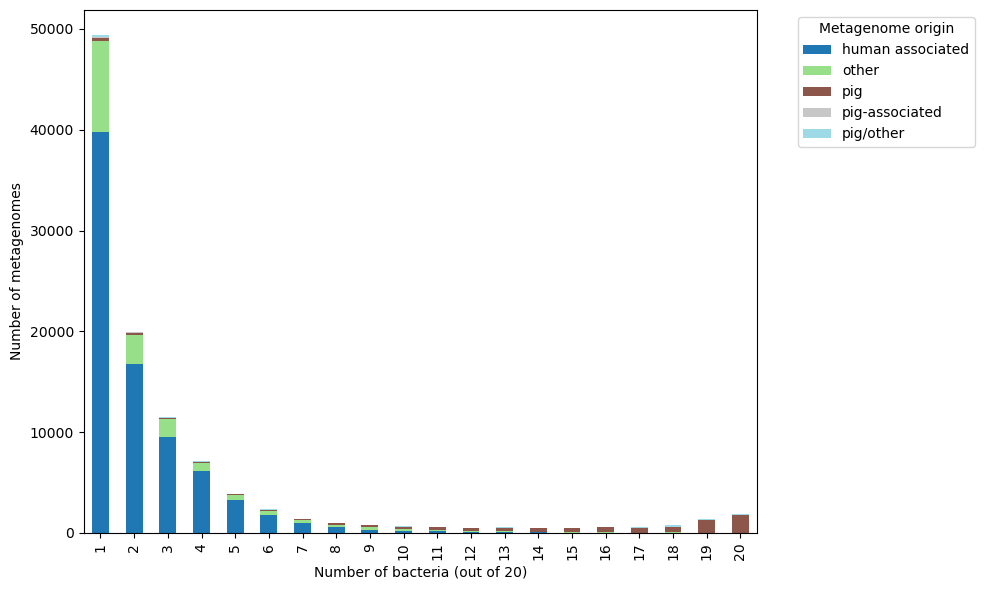

In [40]:
plot_cat(dfm)

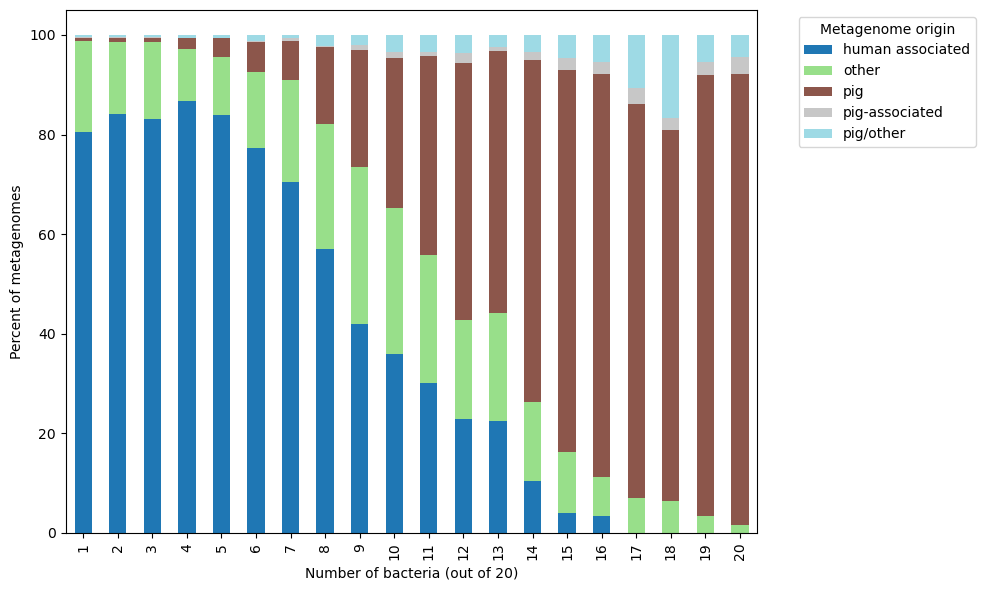

In [43]:
plot_cat_percent(dfm)